# Задание
Необходимо написать функцию для расчёта retention

## Импорт библиотек, настройка графиков

In [1]:
import pandas as pd
import numpy as np
import os
import time
import pytz # устаревший модуль, в более новых версиях заменён на zoneinfo
from pytz.exceptions import UnknownTimeZoneError
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
sns.set_theme(
    style='whitegrid',
    font_scale=2,
    palette='dark',
    rc={'figure.figsize': (16, 9)}
)

## Теоретическая база
Retention (удержание) − важная метрика, показывающая, насколько хорошо пользователи возвращаются в наш продукт (косвенно − насколько он им нравится). Уровень удержания (retention rate) в общем случае можно подсчитать как

$$ RR = \frac{количество\ клиентов\ на\ конец\ периода − количество\ новых\ клиентов\ за\ период}{количество\ клиентов\ в\ начале\ периода} · 100\% $$

Retention бывает 2 типов: retention n-ого дня и rolling retention. В нашем случае retention n-ого дня подойдёт лучше, так как наш продукт используется часто и много, и мы не хотим постоянно пересчитывать rolling retention. 

Для расчёта retention rate n-ого дня мы разобьём всех пользователей на когорты по дням регистрации; посчитаем для каждой когорты retention n-ого дня как отношение числа пользователей, зарегистрированных в игре в определённый день и вернувшихся в игру через n дней, к числу пользователей, зарегистрированных в игре в определённый день; а потом возьмём взвешенное среднее арифметическое retention rate по всем когортам, попадающим в расчётный период:

$$RR = \frac{\sum_{i=1}^m (r_i·b_i)}{\sum_{i=1}^m b_i},$$

где
    m − число когорт;
    $r_i$ − retention n-ого дня i-той когорты;
    $b_i$ − число пользователей в когорте (пользователи, зарегистрировавшиеся в игре в определённый день).

Retention n-ого дня i-той когорты можно рассчитать как

$$r_i = \frac{a_i}{b_i},$$

где $b_i$ − число пользователей в когорте (пользователи, зарегистрировавшиеся в игре в определённый день); а $a_i$ − число пользователей этой когорты, вернувшихся в игру на n-ный день.

Таким образом, retention rate n-ого дня можно представить как

$$RR = \frac{\sum_{i=1}^m a_i}{\sum_{i=1}^m b_i},$$

что гораздо проще для расчётов. Этой формулой мы и будем пользоваться.

## Считывание, предварительное изучение и предобработка данных

In [3]:
path_to_registration_data  = "https://drive.google.com/uc?export=download&id=1jn7-iNFOtDHrY69TLsgFH7P6Gcv3cRYZ"
path_to_authorization_data = "https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/WqlBuzCFovm-3g"

registration_data  = pd.read_csv(path_to_registration_data, sep=';')
authorization_data = pd.read_csv(path_to_authorization_data, sep=';')

Посмотрим, как выглядят данные.

In [4]:
registration_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
authorization_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
registration_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [7]:
authorization_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


10 миллионов строк − многовато. Придётся думать об оптимизации. 
___
Проверка на пропущенные значения в данных:

In [8]:
if registration_data.isnull().sum().sum() == 0:
    print("Пропущенных значений в таблице с данными о регистрации нет.")
elif registration_data.isnull().sum().sum() > 0:
    print("В таблице с данными о регистрации есть пропущенные значения.")
else:
    print("С таблицей с данными о регистрации творится что-то странное.")
    
if authorization_data.isnull().sum().sum() == 0:
    print("Пропущенных значений в таблице с данными о входе нет.")
elif authorization_data.isnull().sum().sum() > 0:
    print("В таблице с данными о входе есть пропущенные значения.")
else:
    print("С таблицей с данными о входе творится что-то странное.")

Пропущенных значений в таблице с данными о регистрации нет.
Пропущенных значений в таблице с данными о входе нет.


___
Проверка на соответствие ID пользователей в таблицах:

In [9]:
registration_data.uid.nunique()

1000000

In [10]:
authorization_data.uid.nunique()

1000000

In [11]:
registration_data.uid.nunique() == authorization_data.uid.nunique()

True

In [12]:
registered_users = set(registration_data.uid.unique())
logged_users     = set(authorization_data.uid.unique())

registered_but_not_logged_users = registered_users.difference(logged_users)
logged_but_not_registered_users = logged_users.difference(registered_users)
        
if len(registered_but_not_logged_users) == 0:
    print("Зарегистрированных, но нелогинившихся пользователей нет.")
else:
    print(f"Зарегистрировались, но не логинились пользователи: {registered_but_not_logged_users}")
      
if len(logged_but_not_registered_users) == 0:
    print("Логинившихся, но незарегистрированных пользователей нет.")
else:
    print(f"Логинились незарегистрированные пользователи: {logged_but_not_registered_users}")

Зарегистрированных, но нелогинившихся пользователей нет.
Логинившихся, но незарегистрированных пользователей нет.


___
Переведём время из UNIX-timestamp'ов в более удобный для восприятия формат. Учтём, что мы в компании считаем даты по центральноевропейскому времени (UTC+1 зимой, UTC+2 летом).

In [13]:
registration_data['reg_date'] = pd.to_datetime(registration_data['reg_ts'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('Europe/Berlin')

authorization_data['auth_date'] = pd.to_datetime(authorization_data['auth_ts'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('Europe/Berlin')

Теперь данные выглядят так:

In [14]:
registration_data.head(2)

,reg_ts,uid,reg_date
0,911382223,1,1998-11-18 10:43:43+01:00
1,932683089,2,1999-07-23 00:38:09+02:00


In [15]:
registration_data.dtypes

reg_ts                              int64
uid                                 int64
reg_date    datetime64[ns, Europe/Berlin]
dtype: object

In [16]:
authorization_data.head(2)

,auth_ts,uid,auth_date
0,911382223,1,1998-11-18 10:43:43+01:00
1,932683089,2,1999-07-23 00:38:09+02:00


In [17]:
authorization_data.dtypes

auth_ts                              int64
uid                                  int64
auth_date    datetime64[ns, Europe/Berlin]
dtype: object

___
Посмотрим диапазоны значений.

In [18]:
registration_data.reg_date.min()

Timestamp('1998-11-18 10:43:43+0100', tz='Europe/Berlin')

In [19]:
registration_data.reg_date.max()

Timestamp('2020-09-23 17:17:24+0200', tz='Europe/Berlin')

In [20]:
authorization_data.auth_date.min()

Timestamp('1998-11-18 10:43:43+0100', tz='Europe/Berlin')

In [21]:
authorization_data.auth_date.max()

Timestamp('2020-09-23 17:17:24+0200', tz='Europe/Berlin')

___
Посмотрим дату первой авторизации у каждого пользователя, совпадает ли она с датой регистрации?

In [22]:
first_auth = authorization_data \
            .groupby('uid', as_index=False) \
            .auth_date \
            .min() \
            .rename(columns={'auth_date': 'first_auth'})

comparision_df = registration_data \
    .merge(first_auth, on='uid')

comparision_df['checkbox'] = comparision_df['reg_date'] != comparision_df['first_auth']

if comparision_df.checkbox.sum() == 0:
    print('''Время регистрации всегда совпадает со временем первого входа пользователя в приложение.
    
Выходит, датафрейм с регистрациями нам не очень-то и нужен. Мы можем обойтись подгрузкой только одной таблицы;
возможно, это сэкономит машинные ресурсы.''')
else:
    print('Время регистрации не всегда совпадает со временем первого входа пользователя в приложение.')

Время регистрации всегда совпадает со временем первого входа пользователя в приложение.
    
Выходит, датафрейм с регистрациями нам не очень-то и нужен. Мы можем обойтись подгрузкой только одной таблицы;
возможно, это сэкономит машинные ресурсы.


___
Посчитаем, сколько уникальных пользователей регистрируется и впервые заходит в игру в каждый из дней, а сколько посещает игру в каждый из дней.

In [23]:
first_auth_by_day = first_auth \
    .resample(rule='D', on='first_auth') \
    .nunique() \
    .rename(columns={'uid': 'users'}) \
    .reset_index()
auth_by_day = authorization_data \
    .resample(rule='D', on='auth_date') \
    .nunique() \
    .rename(columns={'uid': 'users'}) \
    .reset_index()

Отобразим это на графиках.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

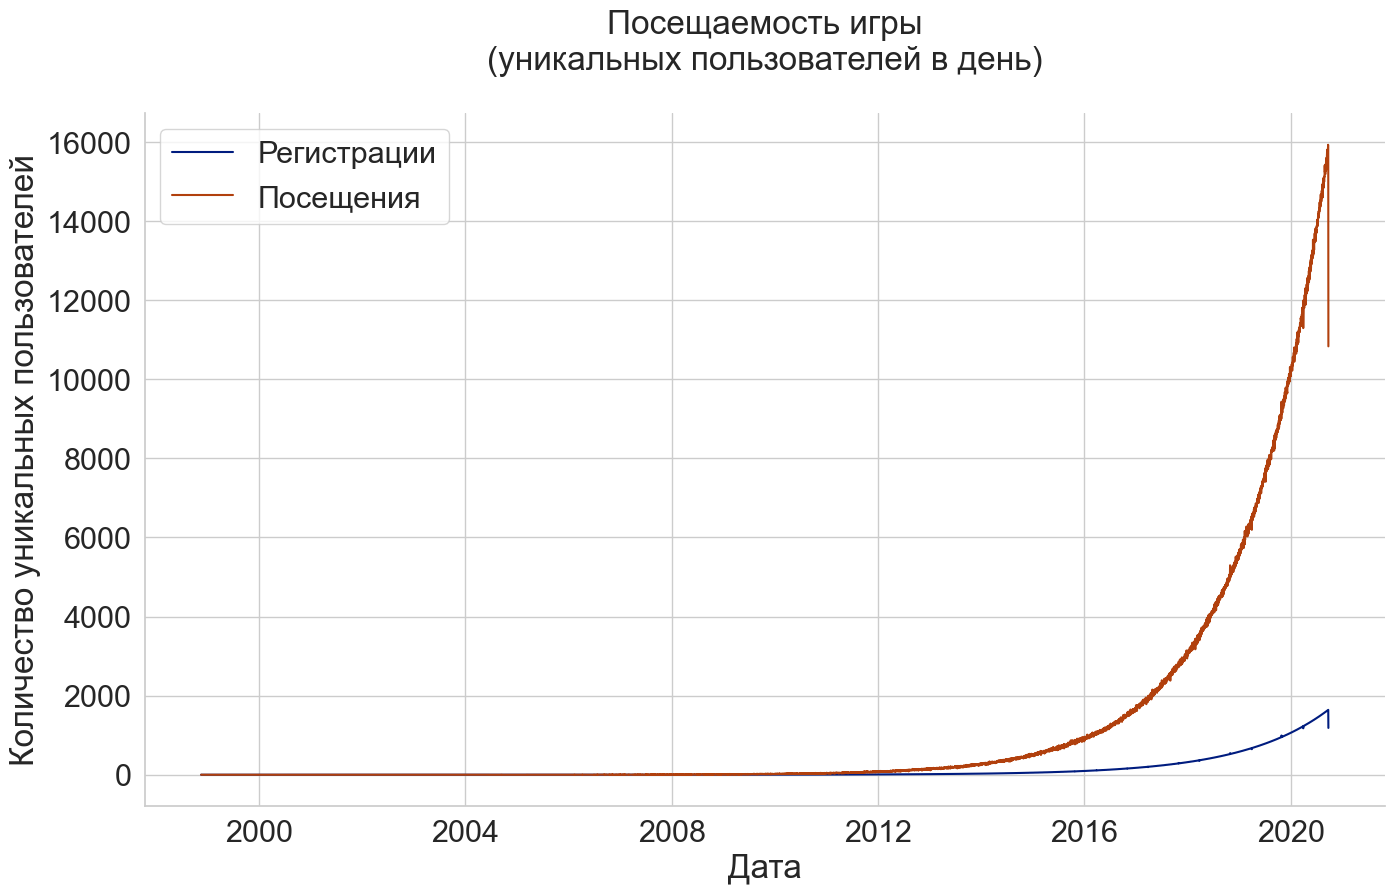

In [24]:
sns.lineplot(
    data=first_auth_by_day, 
    x='first_auth', 
    y='users', 
    label='Регистрации'
)
sns.lineplot(
    data=auth_by_day, 
    x='auth_date', 
    y='users', 
    label='Посещения'
)

plt.title('Посещаемость игры\n(уникальных пользователей в день)\n')
plt.xlabel('Дата')
plt.ylabel('Количество уникальных пользователей')
plt.legend()

sns.despine()

Видим, что долгое время дела у игры шли так себе (возможно, это период разработки и тестов?), показатели улучшились только в последние годы. Возможно, нет смысла считать retention большую часть этого периода, с минимальным количеством регистраций и посещений. В функции мы предусмотрим такую опцию.

Небольшой спад в последний день − следствие того, что этот день неполный.

## Создание функции

In [25]:
def retention_rate(
    n, 
    path_to_file="https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/WqlBuzCFovm-3g",
    timezone="Europe/Berlin",
    limit=0,
    start_cohort=None, 
    end_cohort=None,
    bootstrap_size=10000,
    bootstrap_ci=0.95
):
    '''
    Функция рассчитывает retention n-ного дня. Пользователи разбиваются на когорты по дням регистрации 
        (точно соответствующим дням первого входа в игру, поэтому считываем только файл со входами в игру).
    
    Аргументы:
        n - день, retention на который мы считаем, должен быть целым числом (желательно положительным);
        path_to_file - путь к файлу, где хранятся данные о всех входах пользователей в игру;
            это должен быть csv-файл с разделителем ";", состоящий из 2 столбцов: 'auth_ts' со временем 
            входа в игру (в форме UNIX-таймстемпа) и 'uid' с идентификаторами пользователей;
        timezone - существующий часовой пояс в виде строки;
        limit - нижний предел численности когорт (если мы считаем целесообразным брать для расчётов
            только когорты выше определённой численности);
        start_cohort - начальная когорта периода, за который мы считаем retention (формат ввода 'YYYY-MM-DD');
        end_cohort - конечная когорта периода, за который мы считаем retention (формат ввода 'YYYY-MM-DD');
        bootstrap_size - число подвыборок, которые мы берём при вычислении доверительного интервала для
            retention;
        bootstrap_ci - уровень доверия, с которым мы определяем retention.
    '''
    
    # Стартовые проверки на осмысленность входных значений аргументов.
    if not isinstance(n, int):
        print('Ошибка. n должно быть целым числом.\n')
        return
    
    elif n < 0:
        print('Нет большого смысла в отрицательном n. Нельзя войти в игру раньше первого входа.\n\
Но если хотите, можем посчитать.\n')
        
    elif n == 0:
        print('Нет большого смысла в n=0. Retention нулевого дня всегда 100%.\n\
Но если хотите, можем посчитать.\n')
        
    if not isinstance(bootstrap_size, int):
        print('Ошибка. bootstrap_size должно быть целым числом.\n')
        return
    
    elif bootstrap_size <= 0:
        print('Ошибка. bootstrap_size должно быть положительным числом.\n')
        return
    
    if not isinstance(bootstrap_ci, (int, float)):
        print('Ошибка. bootstrap_ci должно быть числом.\n')
        return
    
    elif not (0 <= bootstrap_ci <= 1):
        print('Ошибка. bootstrap_ci должно быть числом от 0 до 1.\n')
        return
        
    if not isinstance(limit, (int, float)):
        print('Ошибка. Предел численности когорт должен быть числом.\n')
        return
        
    if limit < 0:
        print('Нет большого смысла в отрицательном пределе численности когорт.\n\
Этот показатель не может быть меньше 0.\n\
Но если хотите, можем посчитать.\n')
    
    if not timezone in pytz.all_timezones:
        print('Ошибка. Неизвестная таймзона.\n')
        return
    
    if not start_cohort == None:
        try:
            datetime.strptime(start_cohort, '%Y-%m-%d')
    
        except Exception:
            print("Ошибка. Начальная когорта для расчётов должна быть заведена в формате 'YYYY-MM-DD'\n\
и должна являться валидной датой.\n")
            return
        
    if not end_cohort == None:
        try:
            datetime.strptime(end_cohort, '%Y-%m-%d')
    
        except Exception:
            print("Ошибка. Конечная когорта для расчётов должна быть заведена в формате 'YYYY-MM-DD'\n\
и должна являться валидной датой.\n")
            return
    
    try:
        
        # Считываем данные.
        authorization_data = pd.read_csv(path_to_file, sep=';') 

        # Переводим UNIX-таймстемпы в наше локальное время.
        authorization_data['auth_date'] = pd.to_datetime(authorization_data['auth_ts'], unit='s') \
            .dt.tz_localize('UTC') \
            .dt.tz_convert(timezone) 

        # Если период вычислений не задан, берём в этом качестве самую первую и самую последнюю запись.
        if start_cohort == None:
            start_cohort_dt = authorization_data['auth_date'].min().date()
        else:
            start_cohort_dt = pd.to_datetime(start_cohort).date()

        if end_cohort == None:
            end_cohort_dt = authorization_data['auth_date'].max().date()
        else:
            end_cohort_dt = pd.to_datetime(end_cohort).date()

        # Определяем время первого входа в игру для каждого пользователя.
        first_auth = authorization_data \
            .groupby('uid', as_index=False) \
            .auth_date \
            .min() \
            .rename(columns={'auth_date': 'first_auth'})

        # Отфильтровываем период для расчёта (если нужно).
        if (
               start_cohort_dt != authorization_data['auth_date'].min().date() 
            or end_cohort_dt != authorization_data['auth_date'].max().date()
        ):
            first_auth = first_auth.loc[
                    (first_auth.first_auth.dt.date >= start_cohort_dt) 
                & (first_auth.first_auth.dt.date <= end_cohort_dt)
            ]

        # Разобьём пользователей на когорты по дням. 
        # Для производительности будем хранить ID пользователей во множествах. 
        first_auth_by_day_users = first_auth \
            .resample(rule='D', on='first_auth') \
            .agg({'uid': set}) \
            .reset_index() \
            .rename(columns={'first_auth': 'cohort', 'uid': 'users_set'})

        # Посчитаем количество уникальных пользователей в каждой когорте.
        first_auth_by_day_users['users'] = first_auth_by_day_users['users_set'].apply(len)

        # Отфильтруем слишком маленькие когорты (если нужно).
        if limit > 0:
            first_auth_by_day_users = first_auth_by_day_users.loc[first_auth_by_day_users.users >= limit]

        # Для удобства вычислений переведём формат данных в дни.
        first_auth_by_day_users['cohort'] = first_auth_by_day_users['cohort'].dt.tz_localize(None)

        # Посчитаем для каждой когорты n-ный день (тот, на который мы определяем retention).
        first_auth_by_day_users['n_day'] = first_auth_by_day_users['cohort'] + timedelta(days=n)

        # Посмотрим, какие пользователи заходили в игру в каждый из дней.
        # Использование множеств обеспечит уникальность.
        auth_by_day_users = authorization_data \
            .resample(rule='D', on='auth_date') \
            .agg({'uid': set}) \
            .reset_index() \
            .rename(columns={'auth_date': 'n_day', 'uid': 'n_day_users_set'})

        # Также переведём формат данных в дни.
        auth_by_day_users['n_day'] = auth_by_day_users['n_day'].dt.tz_localize(None)

        # Соединим данные о когортах с данными о посещениях в n-ый день.
        # Когорты, где n-ный день ещё не настал и не попал в данные, придётся дропнуть.
        merged_data = first_auth_by_day_users \
            .merge(auth_by_day_users, on='n_day', how='left') \
            .dropna()

        # Посчитаем, сколько уникальных пользователей из каждой когорты заходили в игру на n-ный день.
        merged_data['recurrent_n_day_users'] = merged_data \
            .apply(lambda x: len(x['users_set'].intersection(x['n_day_users_set'])), axis=1)

        # Теперь у нас есть все данные для расчёта retention.
        RR = merged_data.recurrent_n_day_users.sum() / merged_data.users.sum()
        
        # Определим доверительный интервал для retention. Наши данные могут оказаться распределены 
        # любым образом и не подходить для применения обычных (как параметрических, так и непараметрических)
        # статистических тестов. Поэтому используем бутстрап.
        RR_list = []
        merged_data_subset = merged_data[['users', 'recurrent_n_day_users']] # Оставим только нужное.
        
        # Возьмём подвыборки с повторением из нашего датафрейма для расчёта retention
        # и получим серию значений retention.
        for i in range(bootstrap_size):
            sampled_df = merged_data_subset.sample(frac=1, replace=True)
            sampled_RR = sampled_df.recurrent_n_day_users.sum() / sampled_df.users.sum()
            RR_list.append(sampled_RR)
        
        RR_series = pd.Series(RR_list)
        
        # Из этой серии расчитаем границы доверительного интервала и бутстрапированное среднее.
        ci_low = RR_series.quantile(q=(1-bootstrap_ci)/2) # Нижняя граница ДИ. 
        ci_high = RR_series.quantile(q=1-(1-bootstrap_ci)/2) # Верхняя граница ДИ.
        bootstrap_mean = RR_series.mean() # Бутстрапированное среднее.
        
        return RR, ci_low, ci_high, bootstrap_mean
        
    except ValueError:
        
        print('Ошибка. Нет данных за требуемый промежуток времени;\n\
либо слишком высокий предел численности когорты.\n\n\
И проверьте, что за файл Вы подаёте на вход.\n')
        
        return
    
    except FileNotFoundError:
        
        print('Ошибка. По указанному адресу файл не найден.\n')
        
        return
    
    except KeyError:
        
        print('Ошибка. Заголовки столбцов не те. Это точно нужный файл?\n')
        
        return
    
    except Exception:
        
        print('Ошибка. Неизвестная ошибка.\n')
        
        return

## Проверка работоспособности

Протестируем работоспособность функции в разных ситуациях. Будем заодно засекать её быстродействие.
___
Подсчитаем retention 15 дня за весь период наблюдений:

In [26]:
start_time = time.time()
retention_value = retention_rate(15)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Retention: 4.57%, доверительный интервал: (4.53%, 4.61%).
Время выполнения: 25.67 сек.


___
Теперь подсчитаем retention 10 дня за весь период наблюдений:

In [27]:
start_time = time.time()
retention_value = retention_rate(10)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Retention: 5.17%, доверительный интервал: (5.12%, 5.21%).
Время выполнения: 25.83 сек.


___
Предположим, мы изменим часовой пояс:

In [28]:
start_time = time.time()
retention_value = retention_rate(10, timezone='Asia/Yekaterinburg')
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Retention: 5.16%, доверительный интервал: (5.11%, 5.20%).
Время выполнения: 26.14 сек.


___
Теперь добавим ограничение на размер когорт (если мы не хотим брать слишком маленькие):

In [29]:
start_time = time.time()
retention_value = retention_rate(10, timezone='Asia/Yekaterinburg', limit=100)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Retention: 5.16%, доверительный интервал: (5.12%, 5.21%).
Время выполнения: 24.20 сек.


___
Добавим нижнюю границу периода наблюдений:

In [30]:
start_time = time.time()
retention_value = retention_rate(
    10, 
    timezone='Asia/Yekaterinburg', 
    limit=100, 
    start_cohort='2020-01-01'
)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Retention: 5.19%, доверительный интервал: (5.12%, 5.26%).
Время выполнения: 24.30 сек.


___
Добавим верхнюю границу периода наблюдений:

In [31]:
start_time = time.time()
retention_value = retention_rate(
    10, 
    timezone='Asia/Yekaterinburg', 
    limit=100, 
    start_cohort='2019-09-01',
    end_cohort='2019-09-30'
)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Retention: 4.95%, доверительный интервал: (4.69%, 5.21%).
Время выполнения: 24.11 сек.


___
Попробуем указать промежуток за пределами имеющихся данных:

In [32]:
start_time = time.time()
retention_value = retention_rate(
    10,
    start_cohort='2025-01-01'
)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. Нет данных за требуемый промежуток времени;
либо слишком высокий предел численности когорты.

И проверьте, что за файл Вы подаёте на вход.

Время выполнения: 22.12 сек.


___
Попробуем указать слишком большой предел численности когорты в тот период, где когорт с численностью выше нет:

In [33]:
start_time = time.time()
retention_value = retention_rate(
    10,
    limit=100, 
    start_cohort='2010-07-01',
    end_cohort='2010-12-31'
)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. Нет данных за требуемый промежуток времени;
либо слишком высокий предел численности когорты.

И проверьте, что за файл Вы подаёте на вход.

Время выполнения: 21.93 сек.


___
Попробуем указать невалидную таймзону:

In [34]:
start_time = time.time()
retention_value = retention_rate(10, timezone='MyHomeTimezone')
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. Неизвестная таймзона.

Время выполнения: 0.00 сек.


___
Попробуем подсчитать retention на отрицательный день:

In [35]:
start_time = time.time()
retention_value = retention_rate(-2)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Нет большого смысла в отрицательном n. Нельзя войти в игру раньше первого входа.
Но если хотите, можем посчитать.

Retention: 0.00%, доверительный интервал: (0.00%, 0.00%).
Время выполнения: 25.63 сек.


___
Попробуем подсчитать retention на нулевой день:

In [36]:
start_time = time.time()
retention_value = retention_rate(0)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Нет большого смысла в n=0. Retention нулевого дня всегда 100%.
Но если хотите, можем посчитать.

Retention: 100.00%, доверительный интервал: (100.00%, 100.00%).
Время выполнения: 25.67 сек.


___
Попробуем указать дробное значение n:

In [37]:
start_time = time.time()
retention_value = retention_rate(2.28)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. n должно быть целым числом.

Время выполнения: 0.00 сек.


___
Попробуем указать отрицательный предел численности когорт:

In [38]:
start_time = time.time()
retention_value = retention_rate(10, limit=-10)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Нет большого смысла в отрицательном пределе численности когорт.
Этот показатель не может быть меньше 0.
Но если хотите, можем посчитать.

Retention: 5.17%, доверительный интервал: (5.12%, 5.21%).
Время выполнения: 26.32 сек.


___
Попробуем указать слишком большое n (наши наблюдения не охватывают такой период):

In [39]:
start_time = time.time()
retention_value = retention_rate(10000)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. Нет данных за требуемый промежуток времени;
либо слишком высокий предел численности когорты.

И проверьте, что за файл Вы подаёте на вход.

Время выполнения: 21.76 сек.


___
Попробуем указать период наблюдений в неверном формате:

In [40]:
start_time = time.time()
retention_value = retention_rate(10, end_cohort='31/12/2019')
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. Конечная когорта для расчётов должна быть заведена в формате 'YYYY-MM-DD'
и должна являться валидной датой.

Время выполнения: 0.00 сек.


___
Попробуем указать период наблюдений во внешне верном, но не являющемся валидной датой формате:

In [41]:
start_time = time.time()
retention_value = retention_rate(10, start_cohort='2019-02-29')
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. Начальная когорта для расчётов должна быть заведена в формате 'YYYY-MM-DD'
и должна являться валидной датой.

Время выполнения: 0.00 сек.


___
Попробуем подать на вход функции другой файл:

In [42]:
start_time = time.time()
retention_value = retention_rate(
    10, 
    path_to_file="https://stepik.org/media/attachments/lesson/383540/invoices.csv"
)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. Заголовки столбцов не те. Это точно нужный файл?

Время выполнения: 2.38 сек.


___
Попробуем подать неподходящие число подвыборок:

In [43]:
start_time = time.time()
retention_value = retention_rate(
    10, 
    bootstrap_size=-2000
)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. bootstrap_size должно быть положительным числом.

Время выполнения: 0.00 сек.


Попробуем указать неверный уровень доверия: 

In [44]:
start_time = time.time()
retention_value = retention_rate(
    10, 
    bootstrap_ci=95
)
if retention_value is not None:
    RR, ci_low, ci_high, bootstrap_mean = retention_value 
    print(f"Retention: {RR:.2%}, доверительный интервал: ({ci_low:.2%}, {ci_high:.2%}).")
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} сек.")

Ошибка. bootstrap_ci должно быть числом от 0 до 1.

Время выполнения: 0.00 сек.


## Пример использования функции
Попробуем с помощью функции решить практическую задачу: постоить график изменения retention для пользователей, зарегистрировавшихся в 2019 году. Посмотрим retention первых 15 дней; 20, 30, 45 и 60 дня. (Расчёт займёт несколько минут.)

In [45]:
# Границы периода.
start_date = '2019-01-01'
end_date = '2019-12-31'

# Список дней, на которые считаем retention.
days_for_df = list(range(16)) + [20, 30, 45, 60]

# Результаты работы функции retention на эти дни.
results = [retention_rate(day, start_cohort=start_date, end_cohort=end_date) for day in days_for_df]
retention_for_df, ci_low_for_df, ci_high_for_df, bootstrap_mean_for_df = zip(*results)

# Создаём датафрейм с результатами
df = pd.DataFrame({
    'n_day': days_for_df, 
    'retention': retention_for_df,
    'ci_low': ci_low_for_df,
    'ci_high': ci_high_for_df,
    'bootstrap_mean': bootstrap_mean_for_df
})
df

Нет большого смысла в n=0. Retention нулевого дня всегда 100%.
Но если хотите, можем посчитать.



,n_day,retention,ci_low,ci_high,bootstrap_mean
0,0,1.000000,1.000000,1.000000,1.000000
1,1,0.020111,0.019606,0.020606,0.020111
2,2,0.041078,0.040380,0.041777,0.041080
3,3,0.046588,0.045876,0.047291,0.046589
4,4,0.052456,0.051611,0.053322,0.052455
5,5,0.060207,0.059365,0.061053,0.060207
6,6,0.068864,0.067941,0.069760,0.068862
7,7,0.059454,0.058578,0.060326,0.059460
8,8,0.048076,0.047313,0.048871,0.048080
9,9,0.050604,0.049796,0.051403,0.050600


Нарисуем результат.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

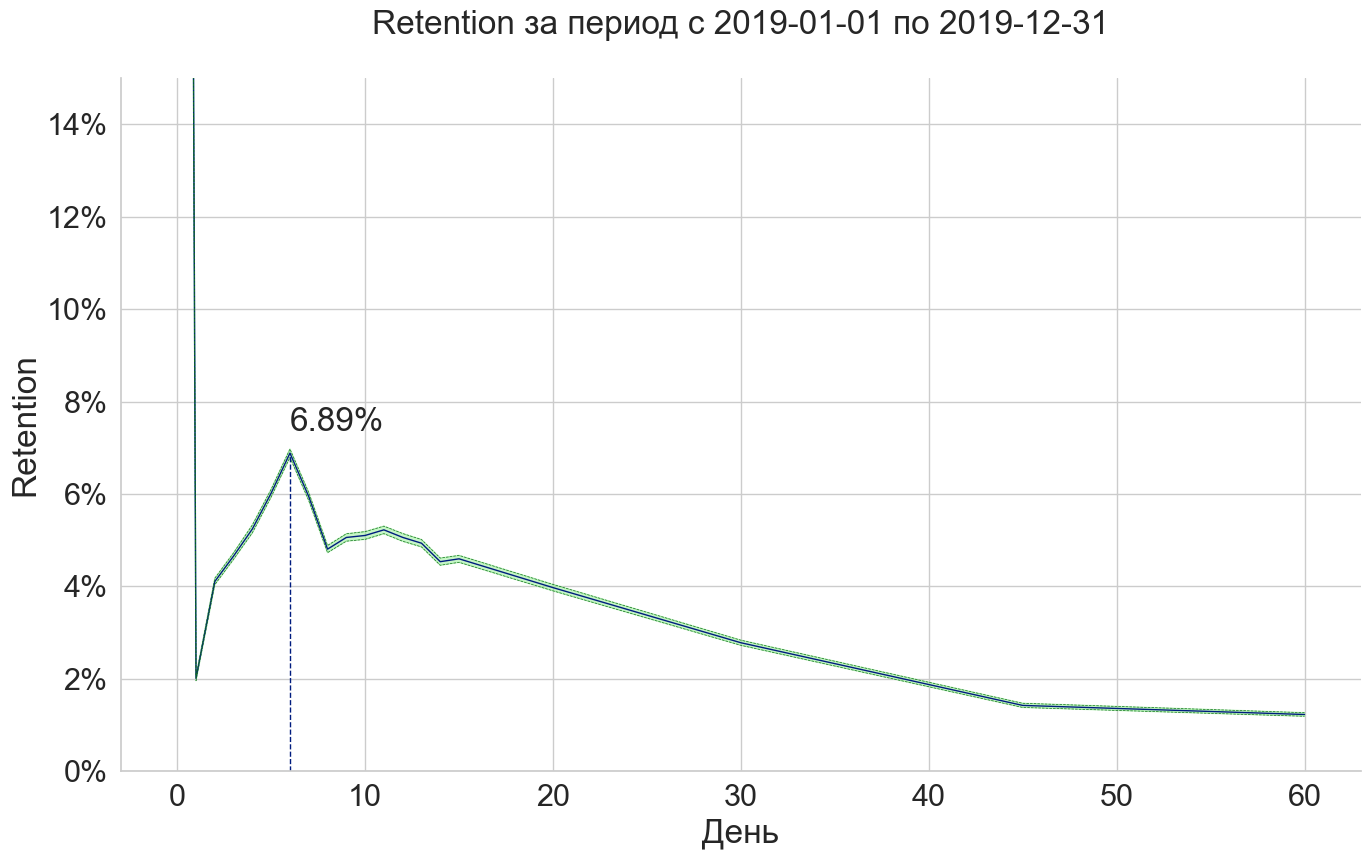

In [46]:
# Рисуем графики.
ax0 = sns.lineplot(data=df, x='n_day', y='retention', color='b', linewidth=1)
ax1 = sns.lineplot(data=df, x='n_day', y='ci_low', color='g', linewidth=0.5, linestyle='--')
ax2 = sns.lineplot(data=df, x='n_day', y='ci_high', color='g', linewidth=0.5, linestyle='--')

# Считаем максимальный (не считая 0-го дня) retention.
max_retention = df[df.n_day !=0].retention.max()
max_day = df[df.retention == max_retention].n_day.values[0]

# Делаем границы и подписи.
ax0.set_ylim(0, round(max_retention, 1) + 0.05)
ax0.set_title(f'Retention за период с {start_date} по {end_date}\n')
ax0.set_xlabel('День')
ax0.set_ylabel('Retention')

# Форматируем тики.
yticks = ax0.get_yticks()
ax0.set_yticklabels([f'{y:.0%}' for y in yticks])

# Помечаем максимум.
plt.plot([max_day, max_day], [0 , max_retention ], color='b', linestyle='--', linewidth=1)
plt.text(max_day, max_retention+0.010,  f'{max_retention:.2%}', ha='left', va='top')

# Зальём область между границами доверительных интервалов.
plt.fill_between(df['n_day'], df['ci_low'], df['ci_high'], color='lightgreen', alpha=0.5)

sns.despine()

Рассмотрим не такой хороший случай: retention для пользователей, зарегистрировавшихся в 2011 году, когда пользователей было гораздо меньше.

In [47]:
# Границы периода.
start_date = '2011-01-01'
end_date = '2011-12-31'

# Список дней, на которые считаем retention.
days_for_df = list(range(16)) + [20, 30, 45, 60]

# Результаты работы функции retention на эти дни.
results = [retention_rate(day, start_cohort=start_date, end_cohort=end_date) for day in days_for_df]
retention_for_df, ci_low_for_df, ci_high_for_df, bootstrap_mean_for_df = zip(*results)

# Создаём датафрейм с результатами
df = pd.DataFrame({
    'n_day': days_for_df, 
    'retention': retention_for_df,
    'ci_low': ci_low_for_df,
    'ci_high': ci_high_for_df,
    'bootstrap_mean': bootstrap_mean_for_df
})
df

Нет большого смысла в n=0. Retention нулевого дня всегда 100%.
Но если хотите, можем посчитать.



,n_day,retention,ci_low,ci_high,bootstrap_mean
0,0,1.000000,1.000000,1.000000,1.000000
1,1,0.020134,0.014468,0.026076,0.020092
2,2,0.039849,0.031987,0.047799,0.039789
3,3,0.053272,0.044620,0.062395,0.053313
4,4,0.054950,0.045792,0.064612,0.054902
5,5,0.058725,0.049700,0.068172,0.058711
6,6,0.066275,0.056555,0.076436,0.066292
7,7,0.057047,0.047839,0.066389,0.056979
8,8,0.042785,0.034731,0.051068,0.042747
9,9,0.039849,0.031976,0.048279,0.039916


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

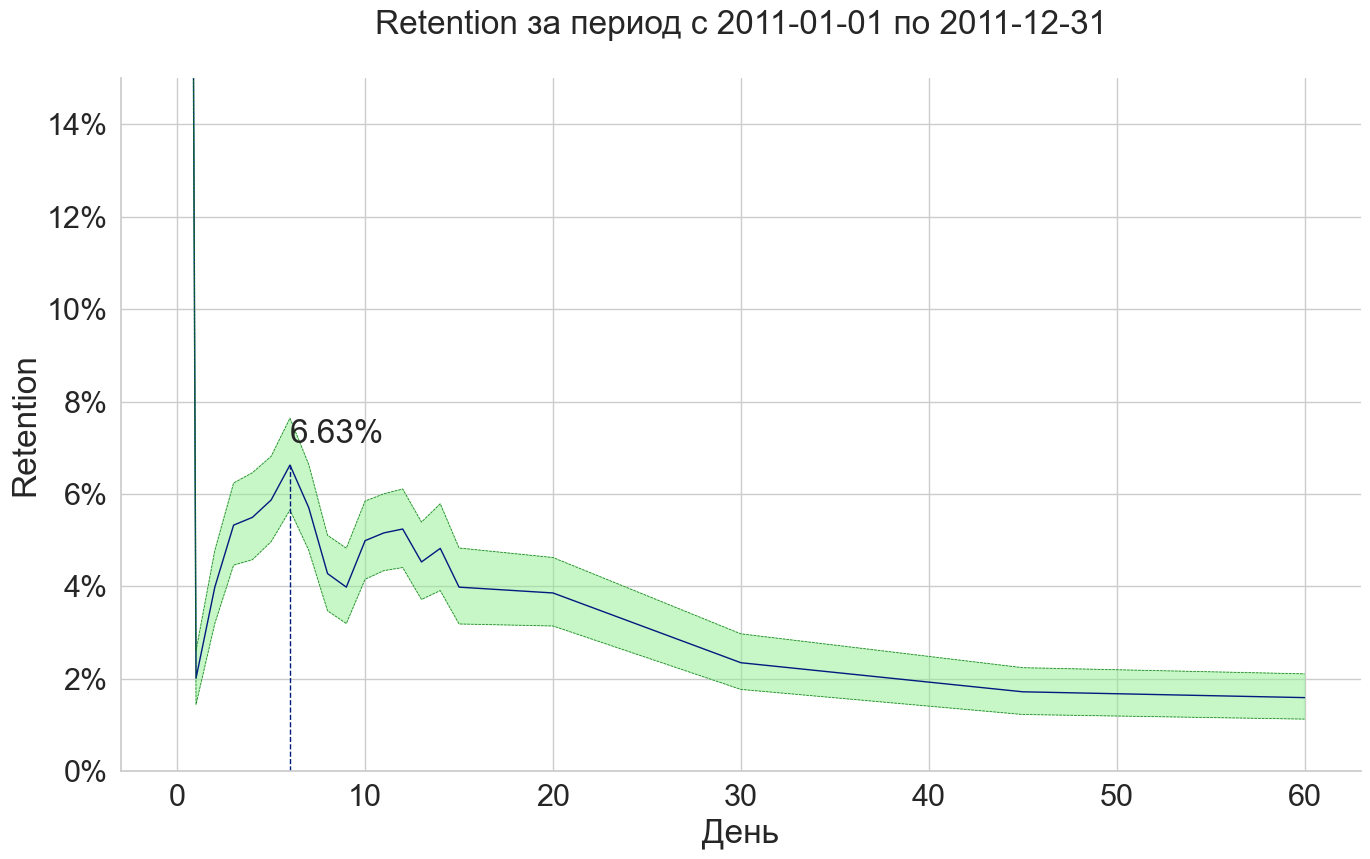

In [48]:
# Рисуем графики.
ax0 = sns.lineplot(data=df, x='n_day', y='retention', color='b', linewidth=1)
ax1 = sns.lineplot(data=df, x='n_day', y='ci_low', color='g', linewidth=0.5, linestyle='--')
ax2 = sns.lineplot(data=df, x='n_day', y='ci_high', color='g', linewidth=0.5, linestyle='--')

# Считаем максимальный (не считая 0-го дня) retention.
max_retention = df[df.n_day !=0].retention.max()
max_day = df[df.retention == max_retention].n_day.values[0]

# Делаем границы и подписи.
ax0.set_ylim(0, round(max_retention, 1) + 0.05)
ax0.set_title(f'Retention за период с {start_date} по {end_date}\n')
ax0.set_xlabel('День')
ax0.set_ylabel('Retention')

# Форматируем тики.
yticks = ax0.get_yticks()
ax0.set_yticklabels([f'{y:.0%}' for y in yticks])

# Помечаем максимум.
plt.plot([max_day, max_day], [0 , max_retention ], color='b', linestyle='--', linewidth=1)
plt.text(max_day, max_retention+0.010,  f'{max_retention:.2%}', ha='left', va='top')

# Зальём область между границами доверительных интервалов.
plt.fill_between(df['n_day'], df['ci_low'], df['ci_high'], color='lightgreen', alpha=0.5)

sns.despine()

При этих условиях доверительные интервалы для retention значительны, и нам гораздо сложнее говорить о статистически значимых изменениях (эти изменения должны быть большими, чтобы быть замеченными).

## Выводы

Нами создана функция retention_rate(), способная считать retention n-ного дня (с требуемым уровнем доверия), считывая данные из файла и переводя их во время необходимого часового пояса. Есть возможность указать период, из которого будут браться когорты для расчёта, а также нижний предел размера когорт. Уровень доверия и число подвыборок для бутстрапа также можно изменить.

Сохраним эту функцию в отдельный файл в качестве модуля. Так мы сможем при необходимости подгружать и использовать её в дальнейшей работе.

In [49]:
module_path = "metrics_functions.py" # Название файла с модулем

if not os.path.exists(module_path):
    with open(module_path, 'w', encoding='utf-8') as file:
        file.write("""import pandas as pd
import pytz # устаревший модуль, в более новых версиях заменён на zoneinfo
from pytz.exceptions import UnknownTimeZoneError
from datetime import timedelta


def retention_rate(
    n, 
    path_to_file="https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/WqlBuzCFovm-3g",
    timezone="Europe/Berlin",
    limit=0,
    start_cohort=None, 
    end_cohort=None,
    bootstrap_size=10000,
    bootstrap_ci=0.95
):
    '''
    Функция рассчитывает retention n-ного дня. Пользователи разбиваются на когорты по дням регистрации 
        (точно соответствующим дням первого входа в игру, поэтому считываем только файл со входами в игру).
    
    Аргументы:
        n - день, retention на который мы считаем, должен быть целым числом (желательно положительным);
        path_to_file - путь к файлу, где хранятся данные о всех входах пользователей в игру;
            это должен быть csv-файл с разделителем ";", состоящий из 2 столбцов: 'auth_ts' со временем 
            входа в игру (в форме UNIX-таймстемпа) и 'uid' с идентификаторами пользователей;
        timezone - существующий часовой пояс в виде строки;
        limit - нижний предел численности когорт (если мы считаем целесообразным брать для расчётов
            только когорты выше определённой численности);
        start_cohort - начальная когорта периода, за который мы считаем retention (формат ввода 'YYYY-MM-DD');
        end_cohort - конечная когорта периода, за который мы считаем retention (формат ввода 'YYYY-MM-DD');
        bootstrap_size - число подвыборок, которые мы берём при вычислении доверительного интервала для
            retention;
        bootstrap_ci - уровень доверия, с которым мы определяем retention.
    '''
    
    # Стартовые проверки на осмысленность входных значений аргументов.
    if not isinstance(n, int):
        print('Ошибка. n должно быть целым числом.\\n')
        return
    
    elif n < 0:
        print('Нет большого смысла в отрицательном n. Нельзя войти в игру раньше первого входа.\\n\\
Но если хотите, можем посчитать.\\n')
        
    elif n == 0:
        print('Нет большого смысла в n=0. Retention нулевого дня всегда 100%.\\n\\
Но если хотите, можем посчитать.\\n')
        
    if not isinstance(bootstrap_size, int):
        print('Ошибка. bootstrap_size должно быть целым числом.\\n')
        return
    
    elif bootstrap_size <= 0:
        print('Ошибка. bootstrap_size должно быть положительным числом.\\n')
        return
    
    if not isinstance(bootstrap_ci, (int, float)):
        print('Ошибка. bootstrap_ci должно быть числом.\\n')
        return
    
    elif not (0 <= bootstrap_ci <= 1):
        print('Ошибка. bootstrap_ci должно быть числом от 0 до 1.\\n')
        return
        
    if not isinstance(limit, (int, float)):
        print('Ошибка. Предел численности когорт должен быть числом.\\n')
        return
        
    if limit < 0:
        print('Нет большого смысла в отрицательном пределе численности когорт.\\n\\
Этот показатель не может быть меньше 0.\\n\\
Но если хотите, можем посчитать.\\n')
    
    if not timezone in pytz.all_timezones:
        print('Ошибка. Неизвестная таймзона.\\n')
        return
    
    if not start_cohort == None:
        try:
            datetime.strptime(start_cohort, '%Y-%m-%d')
    
        except Exception:
            print("Ошибка. Начальная когорта для расчётов должна быть заведена в формате 'YYYY-MM-DD'\\n\\
и должна являться валидной датой.\\n")
            return
        
    if not end_cohort == None:
        try:
            datetime.strptime(end_cohort, '%Y-%m-%d')
    
        except Exception:
            print("Ошибка. Конечная когорта для расчётов должна быть заведена в формате 'YYYY-MM-DD'\\n\\
и должна являться валидной датой.\\n")
            return
    
    try:
        
        # Считываем данные.
        authorization_data = pd.read_csv(path_to_file, sep=';') 

        # Переводим UNIX-таймстемпы в наше локальное время.
        authorization_data['auth_date'] = pd.to_datetime(authorization_data['auth_ts'], unit='s') \\
            .dt.tz_localize('UTC') \\
            .dt.tz_convert(timezone) 

        # Если период вычислений не задан, берём в этом качестве самую первую и самую последнюю запись.
        if start_cohort == None:
            start_cohort_dt = authorization_data['auth_date'].min().date()
        else:
            start_cohort_dt = pd.to_datetime(start_cohort).date()

        if end_cohort == None:
            end_cohort_dt = authorization_data['auth_date'].max().date()
        else:
            end_cohort_dt = pd.to_datetime(end_cohort).date()

        # Определяем время первого входа в игру для каждого пользователя.
        first_auth = authorization_data \\
            .groupby('uid', as_index=False) \\
            .auth_date \\
            .min() \\
            .rename(columns={'auth_date': 'first_auth'})

        # Отфильтровываем период для расчёта (если нужно).
        if (
               start_cohort_dt != authorization_data['auth_date'].min().date() 
            or end_cohort_dt != authorization_data['auth_date'].max().date()
        ):
            first_auth = first_auth.loc[
                    (first_auth.first_auth.dt.date >= start_cohort_dt) 
                & (first_auth.first_auth.dt.date <= end_cohort_dt)
            ]

        # Разобьём пользователей на когорты по дням. 
        # Для производительности будем хранить ID пользователей во множествах. 
        first_auth_by_day_users = first_auth \\
            .resample(rule='D', on='first_auth') \\
            .agg({'uid': set}) \\
            .reset_index() \\
            .rename(columns={'first_auth': 'cohort', 'uid': 'users_set'})

        # Посчитаем количество уникальных пользователей в каждой когорте.
        first_auth_by_day_users['users'] = first_auth_by_day_users['users_set'].apply(len)

        # Отфильтруем слишком маленькие когорты (если нужно).
        if limit > 0:
            first_auth_by_day_users = first_auth_by_day_users.loc[first_auth_by_day_users.users >= limit]

        # Для удобства вычислений переведём формат данных в дни.
        first_auth_by_day_users['cohort'] = first_auth_by_day_users['cohort'].dt.tz_localize(None)

        # Посчитаем для каждой когорты n-ный день (тот, на который мы определяем retention).
        first_auth_by_day_users['n_day'] = first_auth_by_day_users['cohort'] + timedelta(days=n)

        # Посмотрим, какие пользователи заходили в игру в каждый из дней.
        # Использование множеств обеспечит уникальность.
        auth_by_day_users = authorization_data \\
            .resample(rule='D', on='auth_date') \\
            .agg({'uid': set}) \\
            .reset_index() \\
            .rename(columns={'auth_date': 'n_day', 'uid': 'n_day_users_set'})

        # Также переведём формат данных в дни.
        auth_by_day_users['n_day'] = auth_by_day_users['n_day'].dt.tz_localize(None)

        # Соединим данные о когортах с данными о посещениях в n-ый день.
        # Когорты, где n-ный день ещё не настал и не попал в данные, придётся дропнуть.
        merged_data = first_auth_by_day_users \\
            .merge(auth_by_day_users, on='n_day', how='left') \\
            .dropna()

        # Посчитаем, сколько уникальных пользователей из каждой когорты заходили в игру на n-ный день.
        merged_data['recurrent_n_day_users'] = merged_data \\
            .apply(lambda x: len(x['users_set'].intersection(x['n_day_users_set'])), axis=1)

        # Теперь у нас есть все данные для расчёта retention.
        RR = merged_data.recurrent_n_day_users.sum() / merged_data.users.sum()
        
        # Определим доверительный интервал для retention. Наши данные могут оказаться распределены 
        # любым образом и не подходить для применения обычных (как параметрических, так и непараметрических)
        # статистических тестов. Поэтому используем бутстрап.
        RR_list = []
        merged_data_subset = merged_data[['users', 'recurrent_n_day_users']] # Оставим только нужное.
        
        # Возьмём подвыборки с повторением из нашего датафрейма для расчёта retention
        # и получим серию значений retention.
        for i in range(bootstrap_size):
            sampled_df = merged_data_subset.sample(frac=1, replace=True)
            sampled_RR = sampled_df.recurrent_n_day_users.sum() / sampled_df.users.sum()
            RR_list.append(sampled_RR)
        
        RR_series = pd.Series(RR_list)
        
        # Из этой серии расчитаем границы доверительного интервала и бутстрапированное среднее.
        ci_low = RR_series.quantile(q=(1-bootstrap_ci)/2) # Нижняя граница ДИ. 
        ci_high = RR_series.quantile(q=1-(1-bootstrap_ci)/2) # Верхняя граница ДИ.
        bootstrap_mean = RR_series.mean() # Бутстрапированное среднее.
        
        return RR, ci_low, ci_high, bootstrap_mean
        
    except ValueError:
        
        print('Ошибка. Нет данных за требуемый промежуток времени;\\n\\
либо слишком высокий предел численности когорты.\\n\\n\\
И проверьте, что за файл Вы подаёте на вход.\\n')
        
        return
    
    except FileNotFoundError:
        
        print('Ошибка. По указанному адресу файл не найден.\\n')
        
        return
    
    except KeyError:
        
        print('Ошибка. Заголовки столбцов не те. Это точно нужный файл?\\n')
        
        return
    
    except Exception:
        
        print('Ошибка. Неизвестная ошибка.\\n')
        
        return
        """)
    print(f"Файл {module_path} успешно создан и данные записаны.")
else:
    print(f"Файл {module_path} уже существует.")

Файл metrics_functions.py успешно создан и данные записаны.
